<a href="https://colab.research.google.com/github/TheAmirHK/Genetic_Algorithm_Parallelization/blob/main/NSGA3_Codes/NSGA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# In[define the parameters and variables]
INTEGER_INDICES = [0, 1]
CONTINUOUS_INDICES = [2, 3]
BOUNDS = [(1, 10)] * 4

pop_size = 500
generations = 500
MUTATION_RATE = 0.15
CROSSOVER_RATE = 0.92

In [3]:
# In[define the objective functions]
def evaluate(individual):
    x1, x2, x3, x4 = individual
    obj1 = x1**2 + 2*x2**2 - 4*x3**2 + 11*x4**3  # minimize
    obj2 = -(x1 - 2*x2**3 - 10*x3**2 - 11*x4**2 + x1*x2)  # maximize
    obj3 = x1*x2 + x3**2 - 5*x4  # minimize
    return obj1, obj2, obj3

In [4]:
# In[define the constraints]
def _constraints(individual):
    x1, x2, x3, x4 = individual
    return (x1 + x2 <= 5) and (x3**2 + x4**2 - x2*x1*x3 <= 20)

In [5]:
# In[check if fitness values fit1 dominate fit2]
def dominates(fit1, fit2):
    return all(x <= y for x, y in zip(fit1, fit2)) and any(x < y for x, y in zip(fit1, fit2))

In [6]:
# In[mutation function]
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            if i in INTEGER_INDICES:
                individual[i] = random.randint(*BOUNDS[i])
            else:
                individual[i] += random.uniform(-0.5, 0.5)
                individual[i] = max(BOUNDS[i][0], min(BOUNDS[i][1], individual[i]))
    return individual

In [7]:
# In[crossover function]
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]

        for i in INTEGER_INDICES:
            child1[i] = int(round(child1[i]))
            child2[i] = int(round(child2[i]))

        return child1, child2
    return parent1, parent2

In [8]:
# In[non-dominated sorting]
def non_dominated_sort(population, fitness_values):
    fronts = [[]]
    dom_count = {}
    dom_set = {}

    for i, fit in enumerate(fitness_values):
        dom_set[i] = []
        dom_count[i] = 0
        for j, other_fit in enumerate(fitness_values):
            if dominates(fit, other_fit):
                dom_set[i].append(j)
            elif dominates(other_fit, fit):
                dom_count[i] += 1
        if dom_count[i] == 0:
            fronts[0].append(i)

    current_front = 0
    while fronts[current_front]:
        next_front = []
        for i in fronts[current_front]:
            for j in dom_set[i]:
                dom_count[j] -= 1
                if dom_count[j] == 0:
                    next_front.append(j)
        current_front += 1
        fronts.append(next_front)
    return fronts[:-1]

In [9]:
# In[reference point generation]
def generate_reference_points(num_points, num_objectives):
    return np.random.dirichlet(np.ones(num_objectives), num_points)

In [10]:
# In[niching selection]
def niching_selection(fronts, population, ref_points, new_size):
    selected = []
    for front in fronts:
        if len(selected) + len(front) <= new_size:
            selected.extend(front)
        else:
            niche_counts = np.zeros(len(ref_points))
            front_objs = np.array([evaluate(population[i]) for i in front])
            dist = np.linalg.norm(front_objs[:, None] - ref_points, axis=2)
            closest_refs = np.argmin(dist, axis=1)
            for idx in np.argsort(niche_counts[closest_refs]):
                if len(selected) < new_size:
                    selected.append(front[idx])
                    niche_counts[closest_refs[idx]] += 1
                else:
                    break
            break
    return [population[i] for i in selected]

In [11]:
# In[NSGA-III is here !]
def NSGA3(pop_size, generations):
    population = [list((random.randint(1, 10), random.randint(1, 10), random.uniform(1, 10), random.uniform(1, 10)))
                  for _ in range(pop_size)]
    ref_points = generate_reference_points(12, 3)

    for gen in tqdm(range(generations)):
        fitness_values = [evaluate(ind) for ind in population]
        feasible_population = [ind for ind, fit in zip(population, fitness_values) if _constraints(ind)]
        feasible_fitness = [fit for ind, fit in zip(population, fitness_values) if _constraints(ind)]

        fronts = non_dominated_sort(feasible_population, feasible_fitness)
        population = niching_selection(fronts, feasible_population, ref_points, pop_size)

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = random.sample(population, 2)
            c1, c2 = crossover(p1, p2)
            offspring.extend([mutate(c1), mutate(c2)])
        population = offspring[:pop_size]

    final_fitness = [evaluate(ind) for ind in population]
    final_fronts = non_dominated_sort(population, final_fitness)
    pareto_front = [population[i] for i in final_fronts[0]]
    pareto_fitness = [final_fitness[i] for i in final_fronts[0]]
    return pareto_front, pareto_fitness, final_fitness

In [12]:
# In[plot Pareto front]
def plot_pareto(pareto_fitness, all_fitness):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    all_fitness = np.array(all_fitness)
    pareto_fitness = np.array(pareto_fitness)

    ax.view_init(elev=10, azim=-150)
    ax.scatter(all_fitness[:, 0], all_fitness[:, 1], all_fitness[:, 2], color='gray', alpha=0.5, label='All Feasible Solutions')
    ax.scatter(pareto_fitness[:, 0], pareto_fitness[:, 1], pareto_fitness[:, 2], c='r', marker='o', label='Pareto Front')

    ax.set_xlabel("Min Obj 1")
    ax.set_ylabel("Max Obj 2")
    ax.set_zlabel("Min Obj 3")
    ax.set_title("Pareto Front")
    plt.legend()
    plt.show()

100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


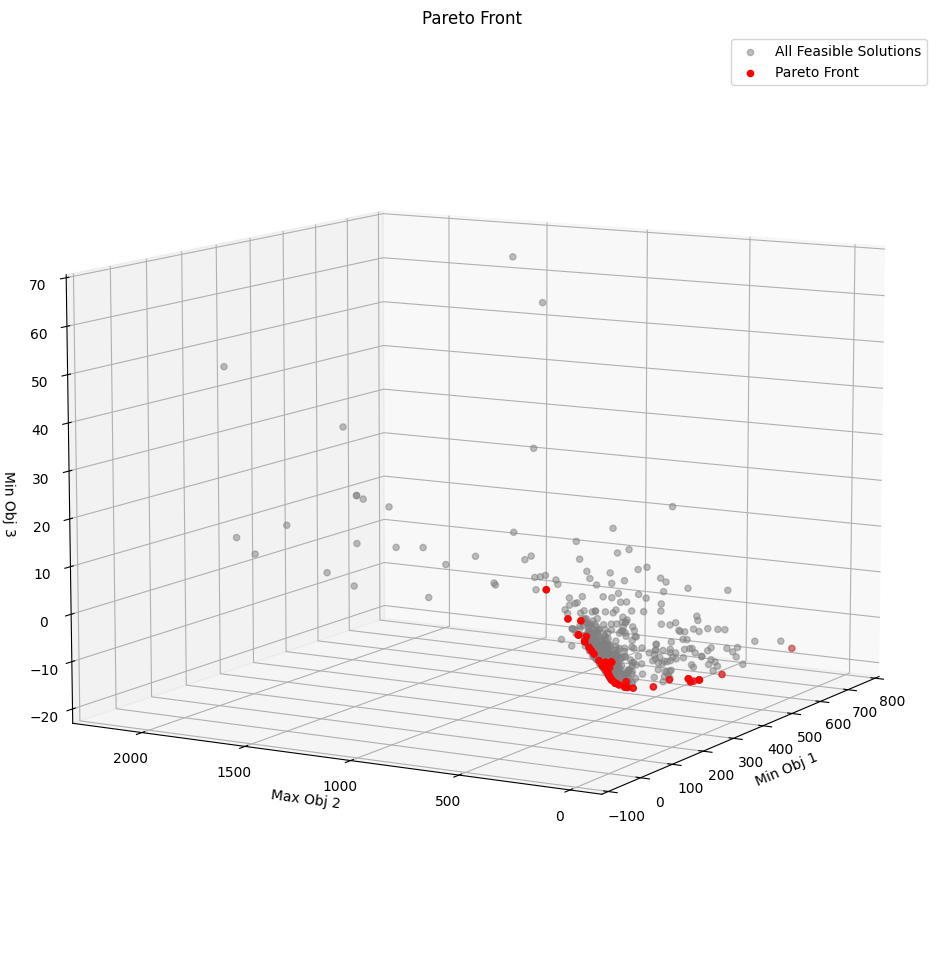

In [13]:
if __name__ == "__main__":
    pareto_front, pareto_fitness, all_fitness = NSGA3(pop_size, generations)
    plot_pareto(pareto_fitness, all_fitness)